In [10]:
#Check number of files in dir
import os

directory_path = 'C:/Users/Bruker/Desktop/Thesis/Data xlsx'

# List all files in the directory
files = os.listdir(directory_path)

# Filter out hidden and temporary files
filtered_files = [file for file in files if not file.startswith('.') and not file.startswith('~$')]

# Count the number of filtered files
file_count = len(filtered_files)

print(f"Number of files in the directory: {file_count}")

Number of files in the directory: 13


In [51]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Loop through each file in the directory
for file_name in filtered_files:
    if file_name.endswith('.xlsx'):
        file_path = os.path.join(directory_path, file_name)
        
        try:
            # Read the Excel file to get all sheet names using openpyxl engine
            xls = pd.ExcelFile(file_path, engine='openpyxl')
            
            # Check if the sheet "A+" exists in the file
            if 'A+' in xls.sheet_names:
                df = pd.read_excel(file_path, sheet_name='A+', engine='openpyxl')
                
                # Check if 'Value' column exists in the sheet
                if 'Value' in df.columns:
                    # Get unique MeterSerialNumbers
                    meter_serial_numbers = df['meterSerialNumber'].unique()
                    
                    # Loop through each MeterSerialNumber and plot the average
                    for meter_serial_number in meter_serial_numbers:
                        meter_df = df[df['meterSerialNumber'] == meter_serial_number]
                        average_value = meter_df['value'].mean()  # Assuming 'Value' is the column to average
                        print(average_value)
                        # Plot the average value
                        plt.figure(figsize=(10, 6))
                        plt.bar(meter_serial_number, average_value)
                        plt.xlabel('MeterSerialNumber')
                        plt.ylabel('Average Value')
                        plt.title(f'Average Value for MeterSerialNumber {meter_serial_number} in Sheet A+')
                        plt.xticks(rotation=45)
                        
                        # Save the plot to a file
                        plot_filename = f"{file_name.replace('.xlsx', '')}_A+_{meter_serial_number}.png"
                        plt.savefig(os.path.join(directory_path, plot_filename))
                        
                        plt.show()
        except FileNotFoundError as e:
            print(f"File not found: {file_path}")
        except Exception as e:
            print(f"An error occurred while processing the file {file_path}: {e}")

In [16]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Prepare the data
values = df['value'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

# Define sequence length
sequence_length = 24  # Example sequence length

# Create sequences and labels
X, y = [], []
for i in range(len(scaled_values) - sequence_length):
    X.append(scaled_values[i:i + sequence_length])
    y.append(scaled_values[i + sequence_length])

X = np.array(X)
y = np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the data to fit the LSTM input shape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print data shapes to verify
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# Ensure data types are correct
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)



X_train shape: (42067, 24, 1)
X_test shape: (10517, 24, 1)
y_train shape: (42067, 1)
y_test shape: (10517, 1)


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

# Define sequence length
sequence_length = 24  # Example sequence length

# Build the LSTM model
model = Sequential()

# First LSTM layer with additional parameters
model.add(LSTM(
    units=75,  # Number of LSTM units
    activation='tanh',  # Activation function
    recurrent_activation='sigmoid',  # Recurrent activation function
    dropout=0.2,  # Fraction of the units to drop for the linear transformation of the inputs
    recurrent_dropout=0.3,  # Fraction of the units to drop for the linear transformation of the recurrent state
    return_sequences=True,  # Return the full sequence
    input_shape=(sequence_length, 1)  # Input shape
))
# Second LSTM layer with additional parameters
model.add(LSTM(
    units=75,  # Number of LSTM units
    activation='tanh',  # Activation function
    recurrent_activation='sigmoid',  # Recurrent activation function
    dropout=0.2,  # Fraction of the units to drop for the linear transformation of the inputs
    recurrent_dropout=0.3  # Fraction of the units to drop for the linear transformation of the recurrent state
))

model.add(BatchNormalization())  # Add batch normalization

# Output layer
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 24, 75)            23100     
                                                                 
 lstm_3 (LSTM)               (None, 75)                45300     
                                                                 
 batch_normalization_1 (Bat  (None, 75)                300       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 1)                 76        
                                                                 
Total params: 68776 (268.66 KB)
Trainable params: 68626 (268.07 KB)
Non-trainable params: 150 (600.00 Byte)
_________________________________________________________________


In [21]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')



Epoch 1/50
1052/1052 [==============================] - 75s 63ms/step - loss: 0.0130 - val_loss: 0.0188
Epoch 2/50
1052/1052 [==============================] - 80s 76ms/step - loss: 0.0099 - val_loss: 0.0100
Epoch 3/50
1052/1052 [==============================] - 73s 70ms/step - loss: 0.0087 - val_loss: 0.0142
Epoch 4/50
1052/1052 [==============================] - 72s 68ms/step - loss: 0.0074 - val_loss: 0.0081
Epoch 5/50
1052/1052 [==============================] - 77s 73ms/step - loss: 0.0065 - val_loss: 0.0055
Epoch 6/50
1052/1052 [==============================] - 76s 72ms/step - loss: 0.0059 - val_loss: 0.0046
Epoch 7/50
1052/1052 [==============================] - 73s 69ms/step - loss: 0.0056 - val_loss: 0.0039
Epoch 8/50
1052/1052 [==============================] - 71s 68ms/step - loss: 0.0053 - val_loss: 0.0111
Epoch 9/50
1052/1052 [==============================] - 80s 76ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 10/50
1052/1052 [==============================] - 82s 78m

In [22]:
# Save the trained model
model.save('New_trained_model.h5')

C:\Users\Bruker\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Assuming X and y are your features and target variables
# Define sequence length
sequence_length = 24  # Example sequence length

# Prepare the data (assuming X and y are already defined)
# Normalize the data if necessary
# Split the data into sequences and labels
# X, y = ...

# Load the saved model
model_path = 'New_trained_model.h5'

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store evaluation metrics
mae_scores = []
mse_scores = []
r2_scores = []

# Cross-validation loop
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # Reshape the data to fit the LSTM input shape
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
    
    # Load the saved model
    model = load_model(model_path)
    
    # Evaluate the model
    predictions = model.predict(X_val)
    predictions = scaler.inverse_transform(predictions)
    y_val_actual = scaler.inverse_transform(y_val.reshape(-1, 1))
    
    mae = mean_absolute_error(y_val_actual, predictions)
    mse = mean_squared_error(y_val_actual, predictions)
    r2 = r2_score(y_val_actual, predictions)
    
    mae_scores.append(mae)
    mse_scores.append(mse)
    r2_scores.append(r2)

# Calculate average metrics
average_mae = np.mean(mae_scores)
average_mse = np.mean(mse_scores)
average_r2 = np.mean(r2_scores)

print(f'Average Mean Absolute Error (MAE): {average_mae}')
print(f'Average Mean Squared Error (MSE): {average_mse}')
print(f'Average R-squared (R²): {average_r2}')

329/329 [==============================] - 5s 12ms/step
Average Mean Absolute Error (MAE): 4.205934637349396
Average Mean Squared Error (MSE): 39.39434680195568
Average R-squared (R²): 0.8639855338201476


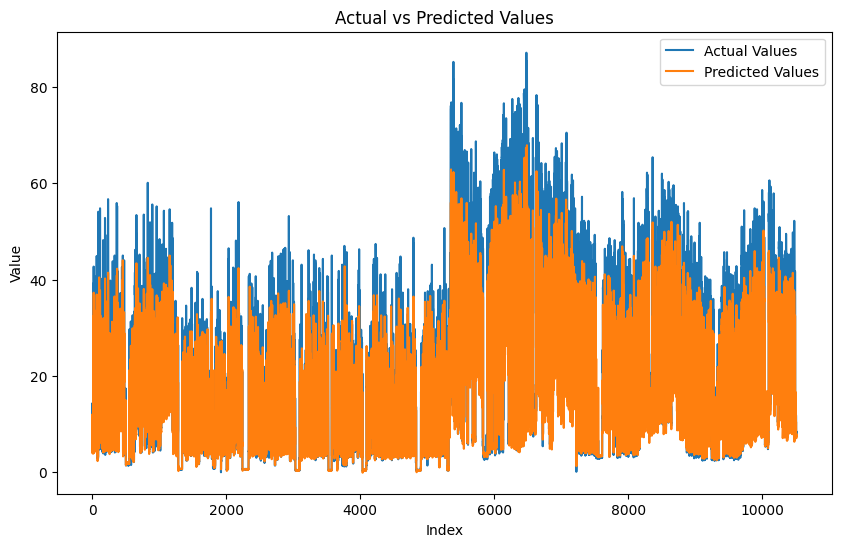

In [47]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values for the last fold
plt.figure(figsize=(10, 6))
plt.plot(y_val_actual, label='Actual Values')
plt.plot(predictions, label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

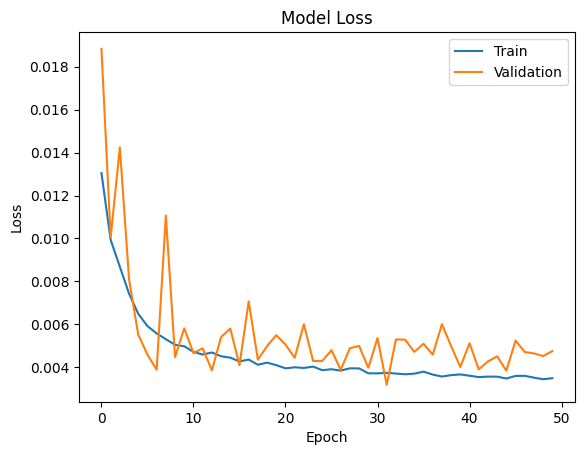

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
